In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import cv2
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import pydensecrf.densecrf as dcrf
# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(gpus, device_type='GPU')

2024-05-08 12:27:11.873538: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-08 12:27:11.874237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-08 12:27:11.934416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA A100 80GB PCIe MIG 1g.10gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 14 deviceMemorySize: 9.50GiB deviceMemoryBandwidth: 225.30GiB/s
2024-05-08 12:27:11.934508: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vsc-hard-mounts/leuven-data/360/vsc36057/miniconda3/envs/myenv3.7/lib/python3.7/site-packages/cv2/../../lib64:
2024-05-08 12:27:11.934558: W tensorflow/stream_executor/platform

In [5]:
IMAGE_DIR = '/data/leuven/360/vsc36057/images-masks-full-black-png/images'
MASK_DIR = '/data/leuven/360/vsc36057/images-masks-full-black-png/masks'
BATCH_SIZE=4
EPOCHS=10
LR = 1e-4
HEIGHT = 512
WIDTH = 512

In [6]:
sample_mask = cv2.imread('/data/leuven/360/vsc36057/images-masks-full-black-png/masks/exp1_F0001-00025.png',cv2.IMREAD_GRAYSCALE)
num_classes = np.max(sample_mask) + 1
height = sample_mask.shape[0]
width = sample_mask.shape[1]
print('the number of total classes: ', num_classes)
print('sample image height {}, width {}'.format(height, width))

the number of total classes:  2
sample image height 1040, width 1392


In [7]:
image_paths = glob(os.path.join(IMAGE_DIR, '*.png'))
image_paths.sort()
mask_paths = glob(os.path.join(MASK_DIR, '*.png'))
mask_paths.sort()
print('total number of images: ', len(image_paths))

total number of images:  480


In [8]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
print('total number of images in training set: ', len(train_x))
print('total number of images in testing set: ', len(test_x))

total number of images in training set:  384
total number of images in testing set:  96


In [9]:
def read_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = image / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [HEIGHT, WIDTH])
    mask = tf.cast(tf.squeeze(mask), dtype=tf.int32)
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    return image, mask

def augment_image_batch1(image, mask):
    new_seed = np.random.randint(100)
    print(image.shape)
    print(mask.shape)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_left_right(image, seed=new_seed)
    mask = tf.image.random_flip_left_right(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

def augment_image_batch2(image, mask):
    new_seed = np.random.randint(100)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_up_down(image, seed=new_seed)
    mask = tf.image.random_flip_up_down(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

In [10]:
train_ds = Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.map(read_image)
train_ds1 = train_ds.map(augment_image_batch1)
train_ds2 = train_ds.map(augment_image_batch2)
train_ds = train_ds.concatenate(train_ds1.concatenate(train_ds2))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(read_image)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

2024-05-08 12:27:27.074488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 12:27:27.074992: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-08 12:27:27.075015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-05-08 12:27:27.075018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      


(512, 512, 3)
(512, 512, 2)


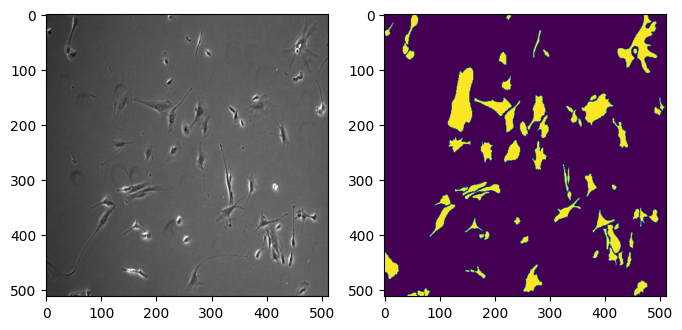

In [11]:
fg, ax = plt.subplots(1,2, figsize=(8,16))
for image, mask in test_ds.take(1):
    ax[0].imshow(image[1,...])
    ax[1].imshow(tf.argmax(mask[1,...],axis=-1))

clear_output()

In [11]:
### swin-unet
!pip install keras-unet-collection -q -U
from keras_unet_collection import models, losses

In [12]:
tf.keras.backend.clear_session()
model = models.swin_unet_2d((512, 512, 3), filter_num_begin=32,
                               n_labels=num_classes, depth=4, stack_num_down=2, stack_num_up=2,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=156, 
                               output_activation='Softmax', shift_window=True,
                               name='swin_unet')
print(model.summary())

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 48)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 32)    525856      patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 32)    14976       patch_embedding[0][0]            
____________________________________________________________________________________

In [14]:
tf.config.experimental_run_functions_eagerly(True)
def focal_loss(predict, true):
    error = keras.losses.categorical_crossentropy(predict, true)
    pt = tf.exp(-error)
    focal_loss = (1 - pt) ** 2 * error
    return tf.reduce_mean(focal_loss)

def mean_iou(predict, true):
    predict = tf.argmax(predict, axis=-1)
    true = tf.argmax(true, axis=-1)
    return keras.metrics.MeanIoU(num_classes=num_classes)(predict, true)




Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [15]:
import tensorflow as tf
from tensorflow import keras

def jaccard_index(predict, true, num_classes):
    """
    Calculate the Jaccard Index, also known as Intersection over Union (IoU), for predicted vs. true labels.
    
    Args:
    - predict: The predicted labels.
    - true: The true labels.
    - num_classes: The number of classes in the labels.
    
    Returns:
    - A scalar representing the mean Jaccard Index across all classes.
    """
    # Convert predictions and true values to one-hot encoded tensors
    predict = tf.argmax(predict, axis=-1)
    true = tf.argmax(true, axis=-1)
    
    # Initialize variables to store the sums of intersections and unions across all classes
    intersection_sum = 0
    union_sum = 0
    
    # Calculate intersection and union for each class
    for class_id in range(num_classes):
        # Calculate intersection and union for the current class
        predict_class = tf.cast(predict == class_id, tf.int32)
        true_class = tf.cast(true == class_id, tf.int32)
        
        intersection = tf.reduce_sum(predict_class * true_class)
        union = tf.reduce_sum(predict_class) + tf.reduce_sum(true_class) - intersection
        
        # Add the current class's intersection and union to the totals
        intersection_sum += intersection
        union_sum += union
    
    # Calculate the mean Jaccard Index (IoU) across all classes
    return intersection_sum / union_sum


In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', JaccardIndex(num_classes=2)])


In [18]:
import os
import pandas as pd
import tensorflow as tf

class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_path, save_freq=5):
        super(CustomModelCheckpoint, self).__init__()
        self.save_path = save_path  # Base path for model saving
        self.save_freq = save_freq  # Frequency of epochs to save the model

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) == 1 or (epoch + 1) % self.save_freq == 0:
            # Define the file path for saving; include the epoch in the filename
            file_path = os.path.join(self.save_path, f'model_epoch_{epoch + 1:02d}.hdf5')
            self.model.save(file_path)
            print(f'\nModel saved to {file_path} at epoch {epoch + 1}')

output_dir = "/data/leuven/360/vsc36057/swin-unet/metrics"
models_dir = "/data/leuven/360/vsc36057/swin-unet/models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

class MetricsHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.metrics_history = {'epoch': [], 'training_jaccard': [], 'validation_jaccard': []}

    def on_epoch_end(self, epoch, logs=None):
        self.metrics_history['epoch'].append(epoch + 1)
        self.metrics_history['training_jaccard'].append(logs.get('train_jaccard_index'))
        self.metrics_history['validation_jaccard'].append(logs.get('val_jaccard_index'))
        metrics_csv_path = os.path.join(output_dir, 'metrics_history.csv')
        pd.DataFrame(self.metrics_history).to_csv(metrics_csv_path, index=False)

# Initialize your callbacks
metrics_history_callback = MetricsHistory()
custom_model_checkpoint_callback = CustomModelCheckpoint(models_dir, save_freq=5)

# Assume model, train_ds, test_ds, and EPOCHS are defined as per your setup
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[metrics_history_callback, custom_model_checkpoint_callback]
)

# After training, convert the CSV file to an Excel file
metrics_csv_path = os.path.join(output_dir, 'metrics_history.csv')
metrics_excel_path = os.path.join(output_dir, 'metrics_history.xlsx')
metrics_df = pd.read_csv(metrics_csv_path)
excel_writer = pd.ExcelWriter(metrics_excel_path, engine='xlsxwriter')
metrics_df.to_excel(excel_writer, index=False, sheet_name='Metrics')
excel_writer.save()


Epoch 1/10
288/288 [==============================] - 530s 2s/step - loss: 0.2062 - accuracy: 0.9344 - jaccard_index: 0.8786 - val_loss: 0.0951 - val_accuracy: 0.9602 - val_jaccard_index: 0.9234

Model saved to /data/leuven/360/vsc36057/swin-unet/models/model_epoch_01.hdf5 at epoch 1
Epoch 2/10
 79/288 [=======>......................] - ETA: 6:08 - loss: 0.0821 - accuracy: 0.9653 - jaccard_index: 0.9329

KeyboardInterrupt: 

In [53]:
model_path = "/data/leuven/360/vsc36057/swin-unet/version2.h5"
model.save(model_path)


In [54]:
for images, masks in test_ds.take(1):
    pred = model.predict(images)

/data/leuven/360/vsc36057/miniconda3/envs/myenv3.7/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [55]:
predictions = np.argmax(pred, axis=-1)
labels = np.argmax(masks, axis=-1)
print(labels.shape)
print(predictions.shape)

(4, 512, 512)
(4, 512, 512)


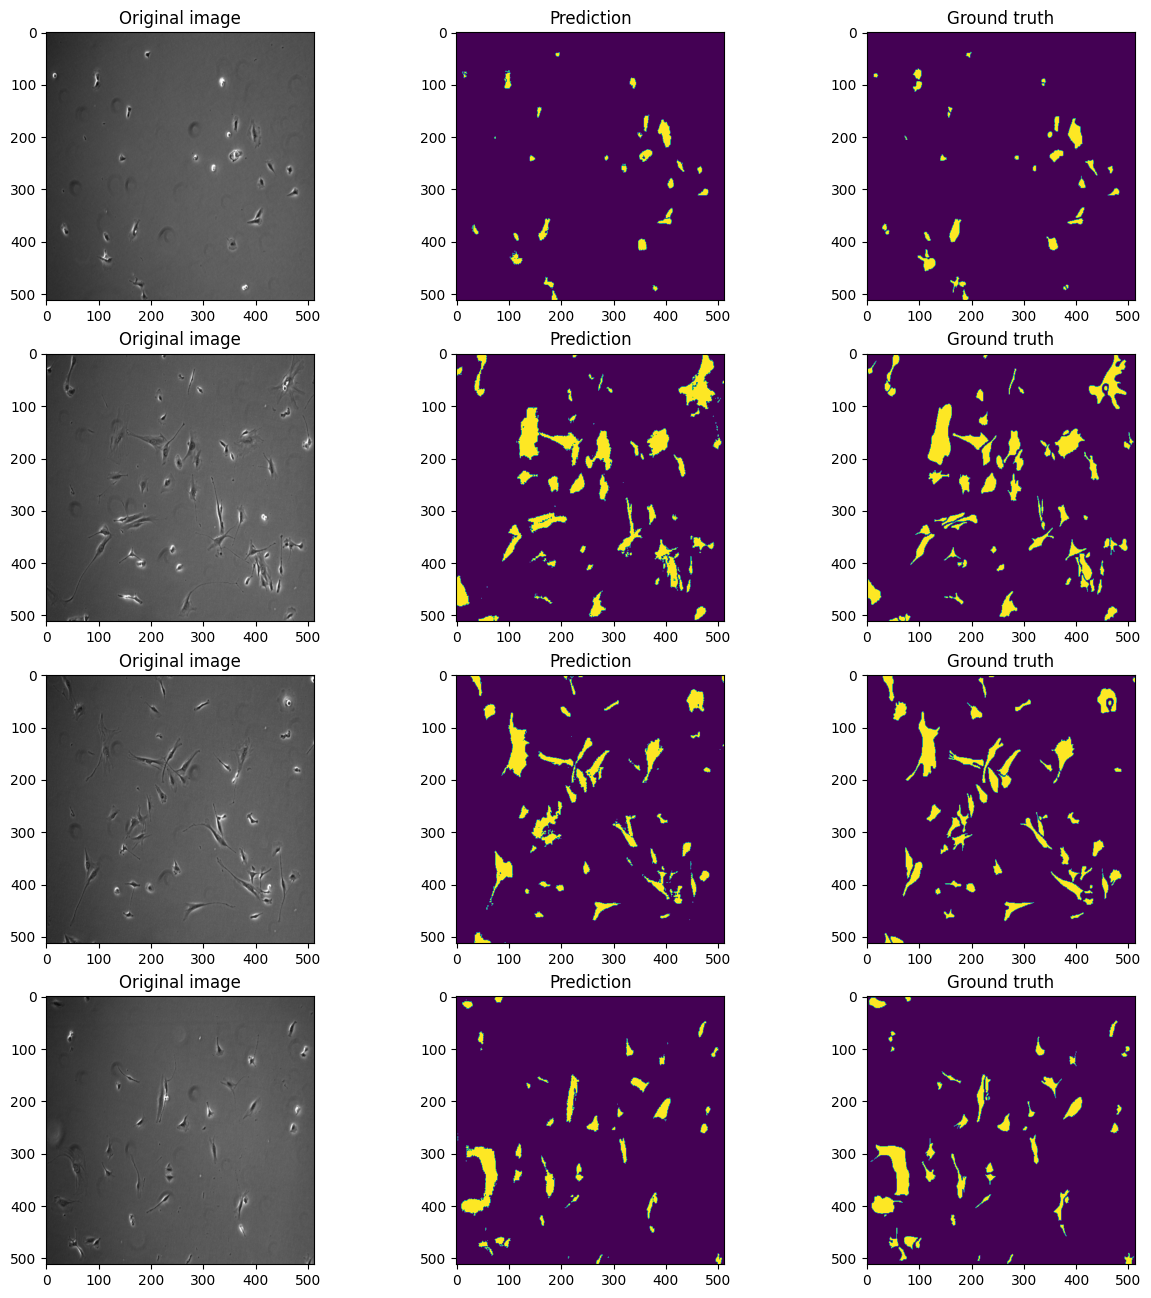

In [56]:
fig, ax = plt.subplots(BATCH_SIZE, 3, figsize=(15, 4 * BATCH_SIZE))
for j in range(BATCH_SIZE):
    ax[j, 0].imshow(images[j, ...].numpy())
    ax[j, 1].imshow(predictions[j, ...].astype('uint8'))
    ax[j, 2].imshow(labels[j, ...])
    ax[j, 0].set_title('Original image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground truth')
plt.show()